# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

# Loading CSV

In [24]:
dataset = pd.read_csv('../results/Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz/Intersect_masterset.csv')
dataset.head()

,range,n1,average1,std1,n2,average2,std2,skewed_1,skewed_2,non_skewed,fastest_algo
0,65518,9862,16767.2,21066.0,9862,16767.2,21066.0,1744,376,9057,skewed_2
1,65518,9862,16767.2,21066.0,10,20967.0,22080.1,433,219,151,non_skewed
2,65518,9862,16767.2,21066.0,4,21096.2,24358.7,396,76,113,skewed_2
3,65518,9862,16767.2,21066.0,48,22803.3,22462.6,467,258,15599,skewed_2
4,65518,9862,16767.2,21066.0,3131,17175.5,21213.4,908,411,1413,skewed_2


# Building Dataset

In [25]:
feature_cols = ['n1', 'n2']
algos = ['skewed_1', 'skewed_2', 'non_skewed']

In [26]:
def get_X(): 
    return dataset.loc[:, feature_cols].values

In [27]:
get_X().shape

(640000, 2)

In [28]:
def get_ys():
    return dataset.loc[:, algos].values

In [29]:
get_ys().shape

(640000, 3)

In [30]:
def get_cy():
    return np.array(dataset.loc[:, 'fastest_algo'].values)

In [31]:
get_cy().shape

(640000,)

In [32]:
def get_cyTimes():
    return np.array([min(a) for a in get_ys()])

In [33]:
get_cyTimes().shape

(640000,)

In [83]:
dataset = dataset.assign(gain=[float(max(a)) / min(a) for a in get_ys()]) 
dataset = dataset[dataset.gain > 2]
dataset = dataset.sort_values(by=['gain'], ascending=False)
dataset.head()

,range,n1,average1,std1,n2,average2,std2,skewed_1,skewed_2,non_skewed,fastest_algo,gain
406636,35512,10038,16514.50,16534.10,2,6064.00,7973.34,45309,58,18,non_skewed,2517.166667
175793,28511,6,3367.17,3711.98,9934,13028.00,13054.10,248,65151,29,non_skewed,2246.586207
406768,35512,10038,16514.50,16534.10,6,9969.83,10880.10,56310,89,33,non_skewed,1706.363636
406765,35512,10038,16514.50,16534.10,4,8799.25,9579.68,50344,57,32,non_skewed,1573.250000
237308,35512,10,6738.30,7863.47,10038,16514.50,16534.10,447,32935,21,non_skewed,1568.333333


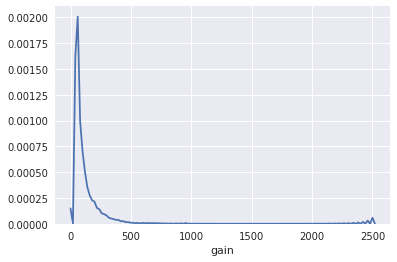

In [84]:
from scipy.stats import norm
sns.set();
sns.distplot(dataset.gain, hist=False)

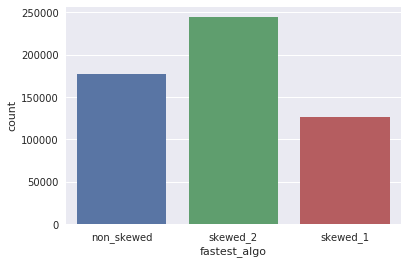

In [85]:
sns.set(color_codes=True)
sns.countplot(x="fastest_algo", data=d)

In [108]:
val_count = dataset["fastest_algo"].value_counts().tolist()
min_count = min(val_count)
count_array = [min_count for i in val_count]
print(count_array)
for i, row in dataset.iterrows():
    algo_index = algos.index(row["fastest_algo"])
    count_array[algo_index]-=1
    if(count_array[algo_index] <= 0):
        dataset.drop(i, inplace=True)
dataset.shape

[126817, 126817, 126817]


Exception KeyboardInterrupt in 'zmq.backend.cython.message.Frame.__dealloc__' ignored


KeyboardInterrupt: 

In [120]:
def getBenchmarkSet():
    benchmarkSet = X.tolist()
    for index, attributes in enumerate(benchmarkSet):
        for times in ys:
            attributes.append(times[index])
        attributes.append(cyTimes[index])
        attributes.append(cy[index])
    return np.array(benchmarkSet)

In [121]:
benchmarkSet = getBenchmarkSet()
benchmarkSet.shape

(39601, 8)

In [122]:
def clfSplit():
    return train_test_split(X, cy, test_size=0.2, random_state=0)

# Calculating value of the project

In [123]:
def percentChange(new, old):
    return ((float(old)/new)-1)

In [124]:
def getAlgoTime(algoName, row):
    for index, algo in enumerate(algos):
        if(algoName == algo):
            return int(row[len(X[0]) + index])
    print('oups none of the available algos')

In [125]:
def getOldSchoolAlgo(n1, n2):
    threshold = 64
    n1 = float(n1)
    n2 = float(n2)
    if (n1 * threshold < n2):
        return 'skewed_1'
    if (n2 * threshold < n1):
        return 'skewed_2'
    return 'non_skewed'

In [126]:
def calculateValueOfML():
    X_train, X_test, y_train, y_test = train_test_split(benchmarkSet, benchmarkSet, test_size=0.3, random_state=0)
    
    clf = DecisionTreeClassifier(max_depth=None, random_state=0)
    clf.fit(X_train[:, 0:len(X[0])], y_train[:,-1])

    mlChosenAlgos = clf.predict(X_test[:, 0:len(X[0])])

    GoodPredictionsCount = 0
    mlTotTime = 0
    osTotTime = 0
    perfectTotTime = 0
    for i, algo in enumerate(mlChosenAlgos):
        if(algo == y_test[i,-1]):
            GoodPredictionsCount += 1
        mlTotTime += getAlgoTime(algo, y_test[i])
        n1 = y_test[i,feature_cols.index('n1')]
        n2 = y_test[i,feature_cols.index('n2')]
        osAlgo = getOldSchoolAlgo(n1 , n2)
        #print(osAlgo)
        osTotTime += getAlgoTime(osAlgo, y_test[i])
        perfectTotTime += int(y_test[i,-2])

    print("Average classification precision: %.2f" % (float(GoodPredictionsCount)/len(mlChosenAlgos)))
    print("Total ml time: %d" % mlTotTime)
    print("Total old school time: %d" % osTotTime)
    print("Machine learning is faster by : %.2f" % percentChange(mlTotTime, osTotTime))
    print("With perfect prediction : %.2f" % percentChange(perfectTotTime, osTotTime))

In [127]:
calculateValueOfML()

['65535.0' '240934.0' '9764.0' '3096' '1253' '41042' '1253' 'skewed_2']
Average classification precision: 0.87
Total ml time: 10222464
Total old school time: 438668374
Machine learning is faster by : 41.91
With perfect prediction : 44.55


# Serialize model

In [ ]:
# from sklearn.externals import joblib

# clf = DecisionTreeClassifier(max_depth=None, random_state=0)
# clf.fit(X, cy)
# joblib.dump(clf, '.joblib')